### Cab-Driver Agent

In [1]:
#Sometimes this does not hide the warnings, we may need to execute this multiple times.
import warnings
warnings.filterwarnings('ignore')
import os
from sys import platform
# This is to avoid issues with Tensorflow if there are duplicate libs
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Let us explore `Time_matrix`

In [4]:
print("Type: {},max: {}, min: {}, average: {}".format(type(Time_matrix),Time_matrix.max(),Time_matrix.min(),Time_matrix.mean()))

Type: <class 'numpy.ndarray'>,max: 11.0, min: 0.0, average: 3.0542857142857143


#### Tracking the state-action pairs for checking convergence


In [5]:
# Initialise states to be tracked
# select any 4 Q-values
tracked_values = [((0, 12, 1), (1, 4)), ((1, 12, 4), (1, 2)),
                  ((2, 14, 2), (2, 3)), ((3, 18, 5), (3, 4))]

In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
# This method plots the tracked states with Q-values on Y axis
def plot_tracked_values(states_tracks, big=False, limit_values_from_last=None):
    if big:
        row = 2
        column = 2
        figsize = (16, 12)
    else:
        row = 1
        column = 4
        figsize = (16, 4)

    fig, axs = plt.subplots(row, column, figsize=figsize)
    
    for index, tracked_value in enumerate(tracked_values):
        if limit_values_from_last:
            item_to_select = min(
                len(states_tracks[tracked_value[0]][tracked_value[1]]),
                limit_values_from_last)

        else:
            item_to_select = len(
                states_tracks[tracked_value[0]][tracked_value[1]])

        xaxis = np.asarray(range(0, item_to_select))
        plt.subplot(row, column, index + 1)
        plt.plot(
            xaxis,
            np.asarray(states_tracks[tracked_value[0]][tracked_value[1]]
                       [-item_to_select:]),)

        plt.title("({},{},{})".format(tracked_value[0][0], tracked_value[0][1],
                                      tracked_value[0][2]) + "_" +
                  "({},{})".format(tracked_value[1][0], tracked_value[1][1]))
        plt.ylabel('Q values')
    plt.show()

In [8]:
# This class is a container for all the params used by the agent
class AgentParam:
    def __init__(self, params):
        self.learning_rate = params.get("learning_rate", 0.01)
        self.action_size = params["action_size"]
        self.state_size = params["state_size"]
        self.action_space = params["action_space"]
        self.epsilon_max = params.get("epsilon_max", 1.0)
        self.epsilon_min = params.get("epsilon_min", 0.0001)
        self.epsilon_decay = params.get("epsilon_decay", 0.0009)
        self.discount_factor = params.get("discount_factor", 0.95)
        self.batch_size = params.get("batch_size", 32)
        self.layers = params["layers"]

    def _print(self):
        attrs = vars(self)
        print("Agent Params: ")
        print("********************************************************")
        for key, value in attrs.items():
            print(key, '->', value)
        print("********************************************************")

In [9]:
# This class implements the epsilon greedy policy for the agent
class EpsilonGreedyPolicy:
    def __init__(self, epsilon_max, epsilon_min, epsilon_decay):
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def get_epsilon(self, episode):
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min
                                      ) * np.exp(-self.epsilon_decay * episode)
        return epsilon

In [10]:
# This class wraps deque with some convenient methods
class ReplayBuffer:
    def __init__(self, batch_size, buffer_size=2000):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def has_enough_experience(self):
        return self.length() > self.batch_size

    def length(self):
        return len(self.memory)

In [11]:
class DQNAgent:
    def __init__(self, agent_param, state_encoder):
        agent_param._print()
        # Define size of state and action
        self.state_size = agent_param.state_size
        self.action_size = agent_param.action_size
        self.action_space = agent_param.action_space

        self.layers = agent_param.layers

        self.discount_factor = agent_param.discount_factor
        self.learning_rate = agent_param.learning_rate
        
        self.epsilon_greedy_policy = EpsilonGreedyPolicy(
            epsilon_max=agent_param.epsilon_max,
            epsilon_min=agent_param.epsilon_min,
            epsilon_decay=agent_param.epsilon_decay)
        
        self.batch_size = agent_param.batch_size
        
        self.memory = ReplayBuffer(batch_size=self.batch_size)
        
        self.epsilon = 1

        # create main model and target model
        self.states_track = collections.defaultdict(dict)
        self.initialise_tracking_states()
        self.state_encoder = state_encoder
        self.model = self.build_model()

    # Build the model for the agent
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets, this will add layers based on the parameter
        for index, layer_dim in enumerate(self.layers):
            if index == 0:
                model.add(
                    Dense(layer_dim,
                          input_dim=self.state_size,
                          activation='relu',
                          kernel_initializer='he_uniform'))
            else:
                model.add(
                    Dense(layer_dim,
                          activation='relu',
                          kernel_initializer='he_uniform'))

        model.add(
            Dense(self.action_size,
                  activation='linear',
                  kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state, episode, requests):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        self.epsilon = self.epsilon_greedy_policy.get_epsilon(episode)
        z = np.random.random()
        state_actions_index, state_actions = requests
        if z > self.epsilon:
            # Exploitation: this gets the action corresponding to max q-value of current state
            state_encode = self.state_encoder(state, self.state_size)
            q_value = self.model.predict(state_encode)
            q_value = q_value[0][state_actions_index]

            action_index = np.argmax(q_value)
            action = state_actions[action_index]
        else:
            # Exploration: here the agent randomly select one of the action
            action = self.action_space[np.random.choice(state_actions_index)]
        return action

    # This method saves the experience
    def save_experience(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    # Train the model
    def train_model(self):
        if not self.memory.has_enough_experience():
            return

        # Sample batch from the memory
        mini_batch = self.memory.sample()
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size))
        actions, rewards, done = [], [], []

        # Set the values of input, action, reward, target and done using memory
        # Note the order of <s,a,r,s',done>
        for index, experience in enumerate(mini_batch):
            state, action, reward, next_state, is_finished = experience

            update_input[index] = self.state_encoder(state,
                                                     self.state_size,
                                                     reshape=False)
            update_target[index] = self.state_encoder(next_state,
                                                      self.state_size,
                                                      reshape=False)

            actions.append(self.action_space.index(action))
            rewards.append(reward)
            done.append(is_finished)

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)

        # get your target Q-value on the basis of terminal state
        for index in range(self.batch_size):
            if done[index]:
                target[index][actions[index]] = rewards[index]
            else:
                target[index][
                    actions[index]] = rewards[index] + self.discount_factor * (
                        np.amax(target_val[index]))

        self.model.fit(update_input,
                       target,
                       batch_size=self.batch_size,
                       epochs=1,
                       verbose=0)

    def memory_length(self):
        return self.memory.length()

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

    # This method initialises the tracking states for the keys defined earlier
    def initialise_tracking_states(self):
        for q_values in tracked_values:
            state = q_values[0]
            action = q_values[1]
            self.states_track[state][action] = []

    # Update the values for the tracking states
    def update_tracking_states(self):
        for state in self.states_track.keys():
            for action in self.states_track[state].keys():
                encoded_state = self.state_encoder(state, self.state_size)
                prediction = self.model.predict(encoded_state)
                action_index = self.action_space.index(list(action))
                self.states_track[state][action].append(
                    prediction[0][action_index])

In [12]:
env = CabDriver()

In [13]:
# This is a helper method to encode the state for the model
def state_encoder(state, state_size, reshape=True):
    state_encode = env.encode_state(state)
    if reshape:
        state_encode = np.reshape(state_encode, [1, state_size])
    return state_encode

### DQN block

In [14]:
# This method wraps the agent learning

def q_learning(agent_param,
               max_epsilon=1.0,
               episodes=50000,
               verbose=False,
               name='dqn_agent_state_as_input_arch'):

    log_threshold = episodes * .001
    threshold = episodes * .001
    model_threshold = episodes * 0.01

    print("number of episodes", episodes)
    print("log_threshold", log_threshold)
    print("threshold", threshold)
    print("model_threshold", model_threshold)

    start_time = time.time()

    agent = DQNAgent(agent_param=agent_param, state_encoder=state_encoder)

    # Container for learning data
    data = {"total_reward": [], "epsilons": [], "episodes": []}

    for episode in range(episodes):

        # tracking total rewards, step count
        total_reward = 0

        state = env.reset()[2]
        is_finished = False

        current_episode = episode + 1

        while not is_finished:

            # Evaluate action, reward and next state
            action = agent.get_action(state, episode, env.get_requests(state))

            reward = env.get_reward(state, action, Time_matrix)

            next_state, is_finished, episode_time_till_now = env.get_next_state(
                state, action, Time_matrix)

            agent.save_experience(state, action, reward, next_state,
                                  is_finished)

            # every time step do the training
            agent.train_model()
            total_reward += reward
            state = next_state

            # Store the rewards
            if is_finished and current_episode % log_threshold == 0:
                data["total_reward"].append(total_reward)
                data["epsilons"].append(agent.epsilon)
                data["episodes"].append(current_episode)

                if verbose:
                    print(
                        "episode: {}, rewards: {}, replay_buffer_size: {}, episode_time: {}, epsilon: {}"
                        .format(current_episode, total_reward,
                                agent.memory_length(), episode_time_till_now,
                                agent.epsilon))

        if (current_episode % model_threshold) == 0:
            print("saving model for episode ", current_episode)
            agent.save("./" + name + "_dqn_cab_driver.h5")

        if (current_episode % threshold) == 0:
            agent.update_tracking_states()

    elapsed_time = time.time() - start_time
    
    print("elapsed_time {} minutes".format(round(elapsed_time / 60, 2)))

    return agent, data

### Setting parameters and hyper paramenters

In [15]:
EPISODES = 20000

agent_param_dict = {
    "action_size": len(env.action_space),
    "state_size": env.state_size,
    "action_space": env.action_space,
    "epsilon_max": 1.0,
    "epsilon_min": 0.000001,
    "epsilon_decay": 0.0005,
    "discount_factor": 0.95,
    "batch_size": 32,
    "layers": [32, 32],
    "learning_rate": 0.001
}

In [16]:
# Starting the learning
agent_param = AgentParam(agent_param_dict)

agent, data = q_learning(agent_param=agent_param,
                                  episodes=EPISODES,
                                  verbose=True,
                                  name="dqn_agent_state_as_input_arch_32_32")

number of episodes 20000
log_threshold 20.0
threshold 20.0
model_threshold 200.0
Agent Params: 
********************************************************
learning_rate -> 0.001
action_size -> 21
state_size -> 36
action_space -> [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3]]
epsilon_max -> 1.0
epsilon_min -> 1e-06
epsilon_decay -> 0.0005
discount_factor -> 0.95
batch_size -> 32
layers -> [32, 32]
********************************************************
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense

episode: 1260, rewards: 473.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.5328586306343094
episode: 1280, rewards: 524.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.5275566086214735
episode: 1300, rewards: 674.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.522307342609131
episode: 1320, rewards: 576.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.5171103076663063
episode: 1340, rewards: 772.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.5119649840851739
episode: 1360, rewards: 561.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.5068708573290881
episode: 1380, rewards: 354.0, replay_buffer_size: 2000, episode_time: 705.0, epsilon: 0.5018274179811283
episode: 1400, rewards: 686.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.4968341616931564
saving model for episode  1400
episode: 1420, rewards: 762.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.491890589135383
episode: 1440, re

episode: 2760, rewards: 849.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2517051220844736
episode: 2780, rewards: 1182.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.2492006242237134
episode: 2800, rewards: 750.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.2467210465330426
saving model for episode  2800
episode: 2820, rewards: 1286.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.2442661410526258
episode: 2840, rewards: 1084.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.24183566228986927
episode: 2860, rewards: 715.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.2394293671948713
episode: 2880, rewards: 792.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2370470151361171
episode: 2900, rewards: 1156.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.23468836787641548
episode: 2920, rewards: 1058.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.232353189549075
episode: 

episode: 4240, rewards: 1363.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.12009253924050767
episode: 4260, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.11889760845974628
episode: 4280, rewards: 1569.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.11771456743891176
episode: 4300, rewards: 1165.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.11654329787291605
episode: 4320, rewards: 1613.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.11538368263382658
episode: 4340, rewards: 1333.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.114235605759153
episode: 4360, rewards: 1249.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.11309895244025121
episode: 4380, rewards: 1156.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.111973609010842
episode: 4400, rewards: 1497.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.11085946293564473
saving model for episode  4400
e

episode: 5720, rewards: 1531.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.05729834450798655
episode: 5740, rewards: 1372.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.0567282264044009
episode: 5760, rewards: 1212.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.056163781070728516
episode: 5780, rewards: 1165.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.0556049520619657
episode: 5800, rewards: 1529.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.055051683494745846
saving model for episode  5800
episode: 5820, rewards: 1651.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.054503920041751204
episode: 5840, rewards: 1382.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05396160692617996
episode: 5860, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0534246899162687
episode: 5880, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.052893115319868

episode: 7200, rewards: 1580.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.027338360387163106
saving model for episode  7200
episode: 7220, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02706634910645192
episode: 7240, rewards: 1632.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.02679704438320592
episode: 7260, rewards: 1433.0, replay_buffer_size: 2000, episode_time: 707.0, epsilon: 0.026530419286728345
episode: 7280, rewards: 1566.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.026266447154287376
episode: 7300, rewards: 1521.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02600510158844977
episode: 7320, rewards: 1474.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.025746356454441177
episode: 7340, rewards: 1804.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.025490185877532556
episode: 7360, rewards: 1486.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.0252365642

episode: 8680, rewards: 1611.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.013044035054329006
episode: 8700, rewards: 1834.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.012914254687123006
episode: 8720, rewards: 1381.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.012785765656146801
episode: 8740, rewards: 1435.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.012658555112390205
episode: 8760, rewards: 1548.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012532610334692858
episode: 8780, rewards: 1455.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.012407918728472023
episode: 8800, rewards: 1170.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012284467824463168
saving model for episode  8800
episode: 8820, rewards: 1260.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012162245277473007
episode: 8840, rewards: 1540.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.0120412

episode: 10160, rewards: 1647.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.0062240135250490195
episode: 10180, rewards: 1366.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.006162093505893607
episode: 10200, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.006100789601223045
saving model for episode  10200
episode: 10220, rewards: 1647.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006040095680595782
episode: 10240, rewards: 1251.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005980005674569168
episode: 10260, rewards: 1498.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.005920513574092539
episode: 10280, rewards: 1656.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.005861613429906262
episode: 10300, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.0058032993519468385
episode: 10320, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilo

episode: 11620, rewards: 1563.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0029999261631740446
episode: 11640, rewards: 1282.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0029700863492764912
episode: 11660, rewards: 1579.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.002940543446488115
episode: 11680, rewards: 1485.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0029112945004940156
episode: 11700, rewards: 1305.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002882336586375219
episode: 11720, rewards: 1381.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.0028536668083161813
episode: 11740, rewards: 1440.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0028252822993152034
episode: 11760, rewards: 1749.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.0027971802208977357
episode: 11780, rewards: 1160.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.002769357762832516
epis

episode: 13080, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0014462094786502888
episode: 13100, rewards: 1606.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.0014318294040704406
episode: 13120, rewards: 1676.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.0014175924136233611
episode: 13140, rewards: 1395.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0014034970835981404
episode: 13160, rewards: 1556.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0013895420044500323
episode: 13180, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0013757257806594912
episode: 13200, rewards: 1276.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.001362047030592625
saving model for episode  13200
episode: 13220, rewards: 1610.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0013485043863630274
episode: 13240, rewards: 1485.0, replay_buffer_size: 2000, episode_time: 719.0, e

episode: 14520, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0007044589740677628
episode: 14540, rewards: 1254.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.000697459440325149
episode: 14560, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0006905295531069519
episode: 14580, rewards: 1575.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0006836686194186761
episode: 14600, rewards: 1336.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.0006768759531612345
saving model for episode  14600
episode: 14620, rewards: 1595.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.0006701508750623408
episode: 14640, rewards: 1503.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0006634927126085803
episode: 14660, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0006569007999781605
episode: 14680, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 715.0, e

episode: 15960, rewards: 1237.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0003434102426027708
episode: 15980, rewards: 1637.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.0003400032037628853
episode: 16000, rewards: 1530.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.00033663006552588
saving model for episode  16000
episode: 16020, rewards: 1922.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0003332904905751197
episode: 16040, rewards: 1345.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0003299841449503268
episode: 16060, rewards: 1556.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0003267106980141833
episode: 16080, rewards: 1371.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0003234698224192678
episode: 16100, rewards: 1592.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.00032026119407531985
episode: 16120, rewards: 1548.0, replay_buffer_size: 2000, episode_time: 719.0, e

episode: 17400, rewards: 1539.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00016766895805069975
saving model for episode  17400
episode: 17420, rewards: 1199.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.0001660105742092424
episode: 17440, rewards: 1542.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00016436869156271524
episode: 17460, rewards: 1489.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.00016274314592148537
episode: 17480, rewards: 1586.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.00016113377472963406
episode: 17500, rewards: 1552.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.00015954041704870095
episode: 17520, rewards: 1568.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.0001579629135415899
episode: 17540, rewards: 1567.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00015640110645663615
episode: 17560, rewards: 1417.0, replay_buffer_size: 2000, episode_time: 7

episode: 18840, rewards: 1494.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 8.212649132967609e-05
episode: 18860, rewards: 1584.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 8.1319269253599e-05
episode: 18880, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 8.052007917138037e-05
episode: 18900, rewards: 1548.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 7.972884116334584e-05
episode: 18920, rewards: 1458.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 7.894547610503522e-05
episode: 18940, rewards: 1705.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 7.816990565928989e-05
episode: 18960, rewards: 1402.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 7.740205226841897e-05
episode: 18980, rewards: 1530.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 7.664183914644344e-05
episode: 19000, rewards: 1516.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 7.588919027141767e-05
sav

### Tracking Convergence

In [17]:
def plot_learning_with_epsilon(x,
                               rewards,
                               epsilons,
                               file_name=None,
                               figsize=(16, 10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C3")
    ax.set_xlabel("Episode", color="C3")
    ax.set_ylabel("Epsilon", color="C3")
    ax.tick_params(axis='x', colors="C3")
    ax.tick_params(axis='y', colors="C3")

    N = len(rewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(rewards[max(0, t - 20):(t + 1)])

    ax2.scatter(x, running_avg, color="C8")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Total Reward', color="C8")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C8")

    if file_name:
        plt.savefig(file_name)

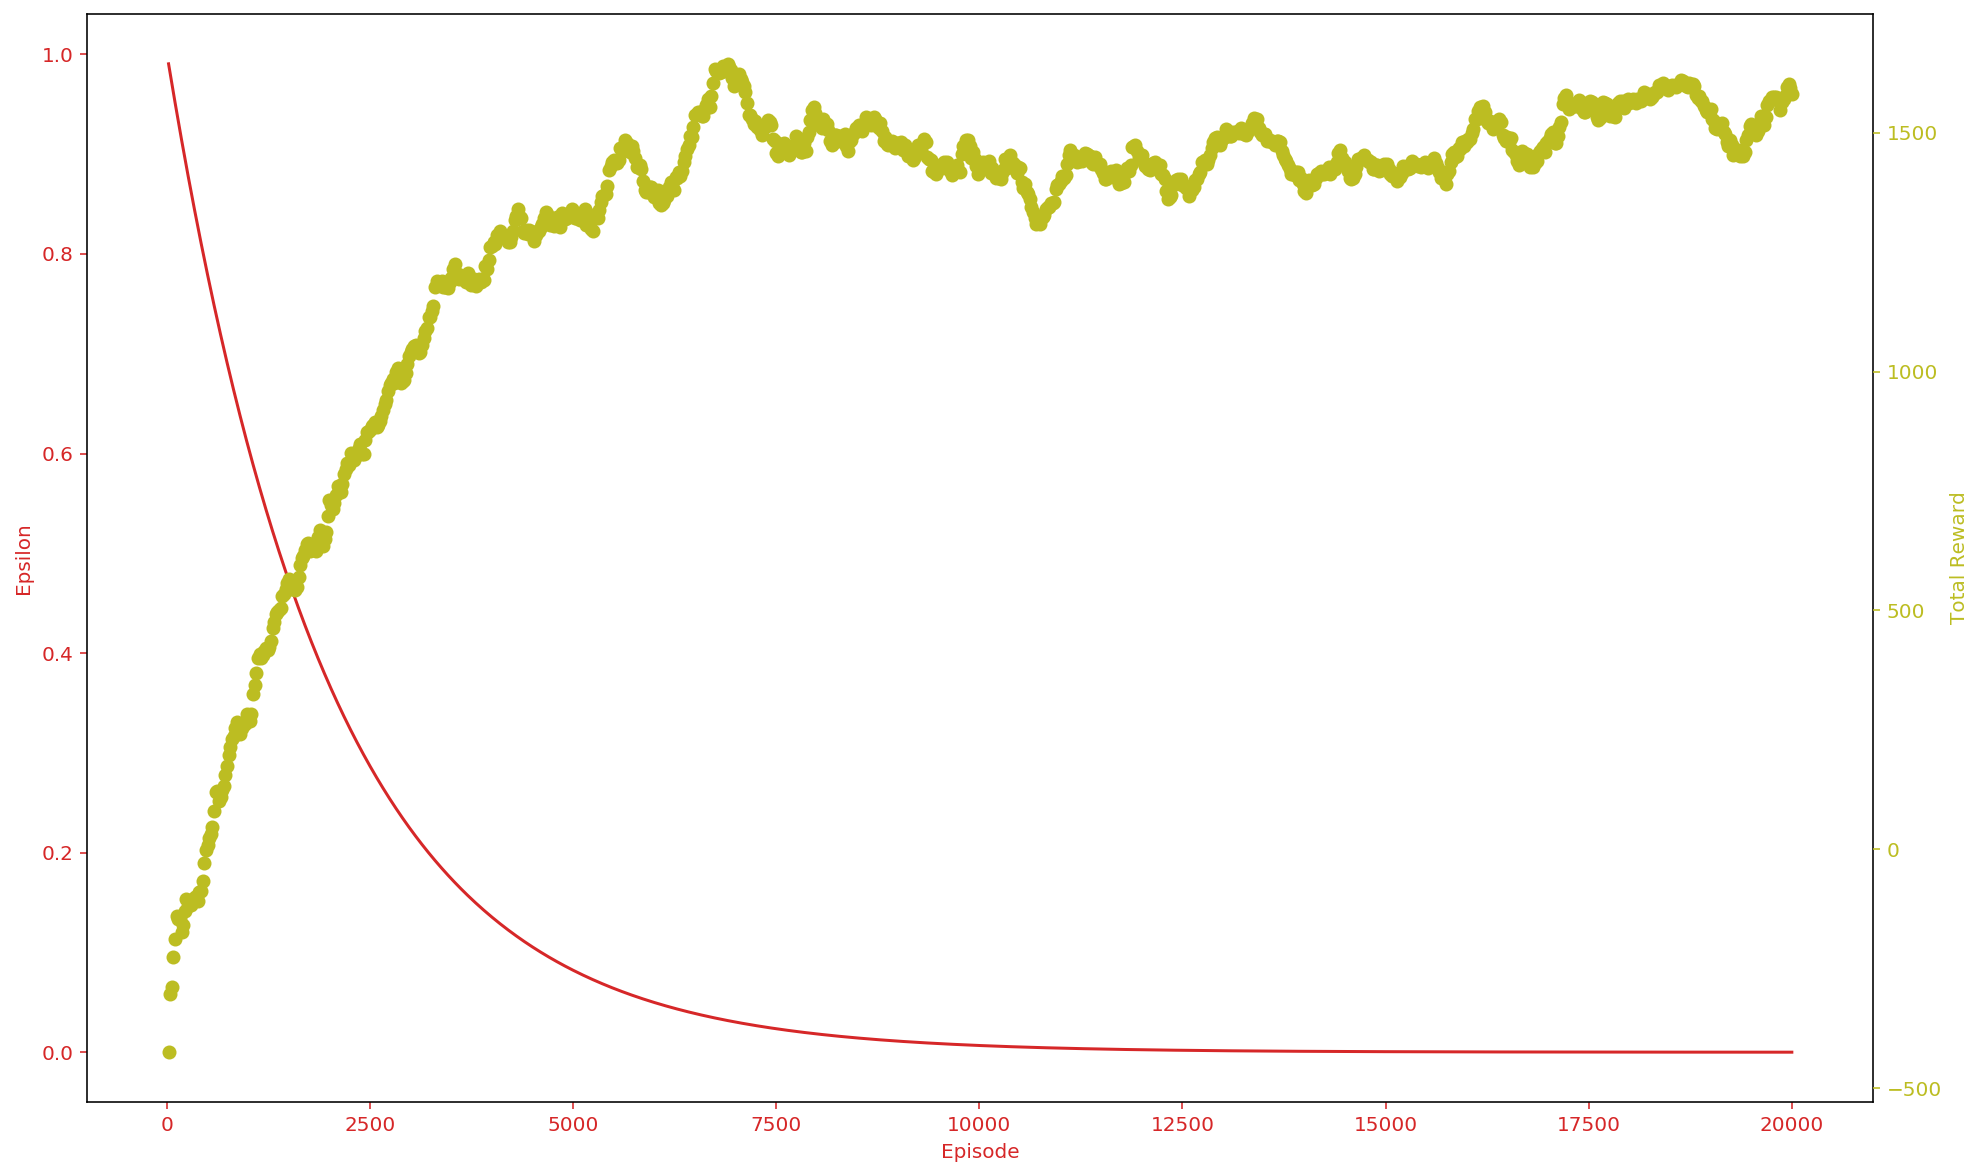

In [18]:
plot_learning_with_epsilon(data["episodes"],
                           data["total_reward"],
                           data["epsilons"],
                           file_name="dqn_agent_state_as_input_arch_32_32")

This graph is showing running average of last 20 entries of rewards as the epsilon decreases with episodes. 

# We can see that the agent converges at a reward of around 1500.

## Average of last 500 episodes 

The following shows the average of the last 500 episodes, as we are saving reward per 20 episodes, so the last 25 entries will correspond to last 500 episodes

In [19]:
np.mean(data["total_reward"][-25:])

1567.4

### The following plot shows the convergence of the states mentioned in `tracked_values` above. We were tracking Q-values of 4 state-action pairs. We can see that the Q-values have converged.

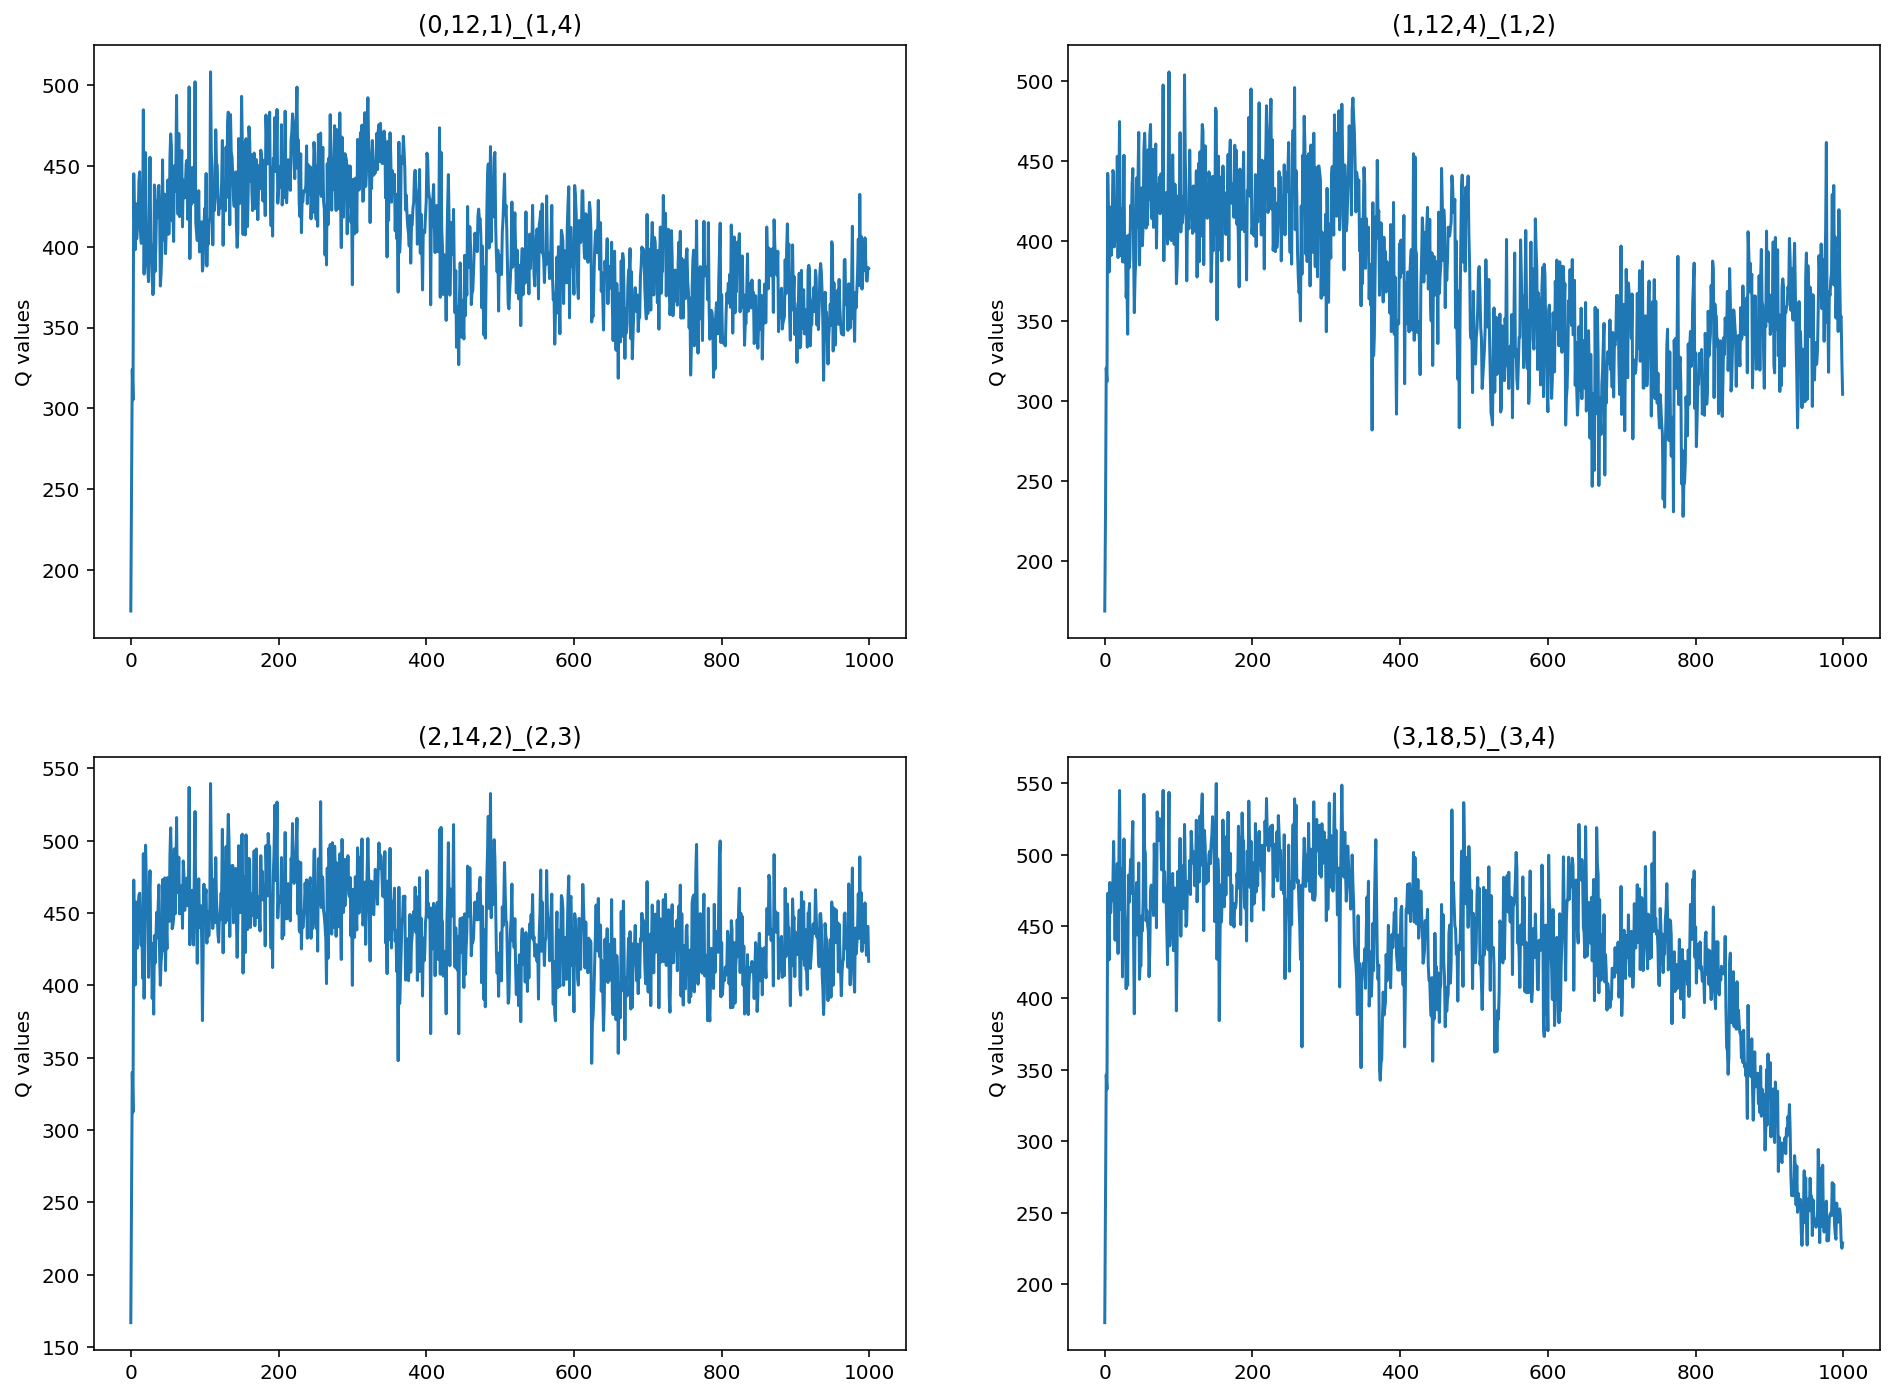

In [20]:
plot_tracked_values(agent.states_track, big=True)

### The following plots shows the Q-values of the last 100 entries which corresponds to 2000 episodes. We can see that the values are converged.

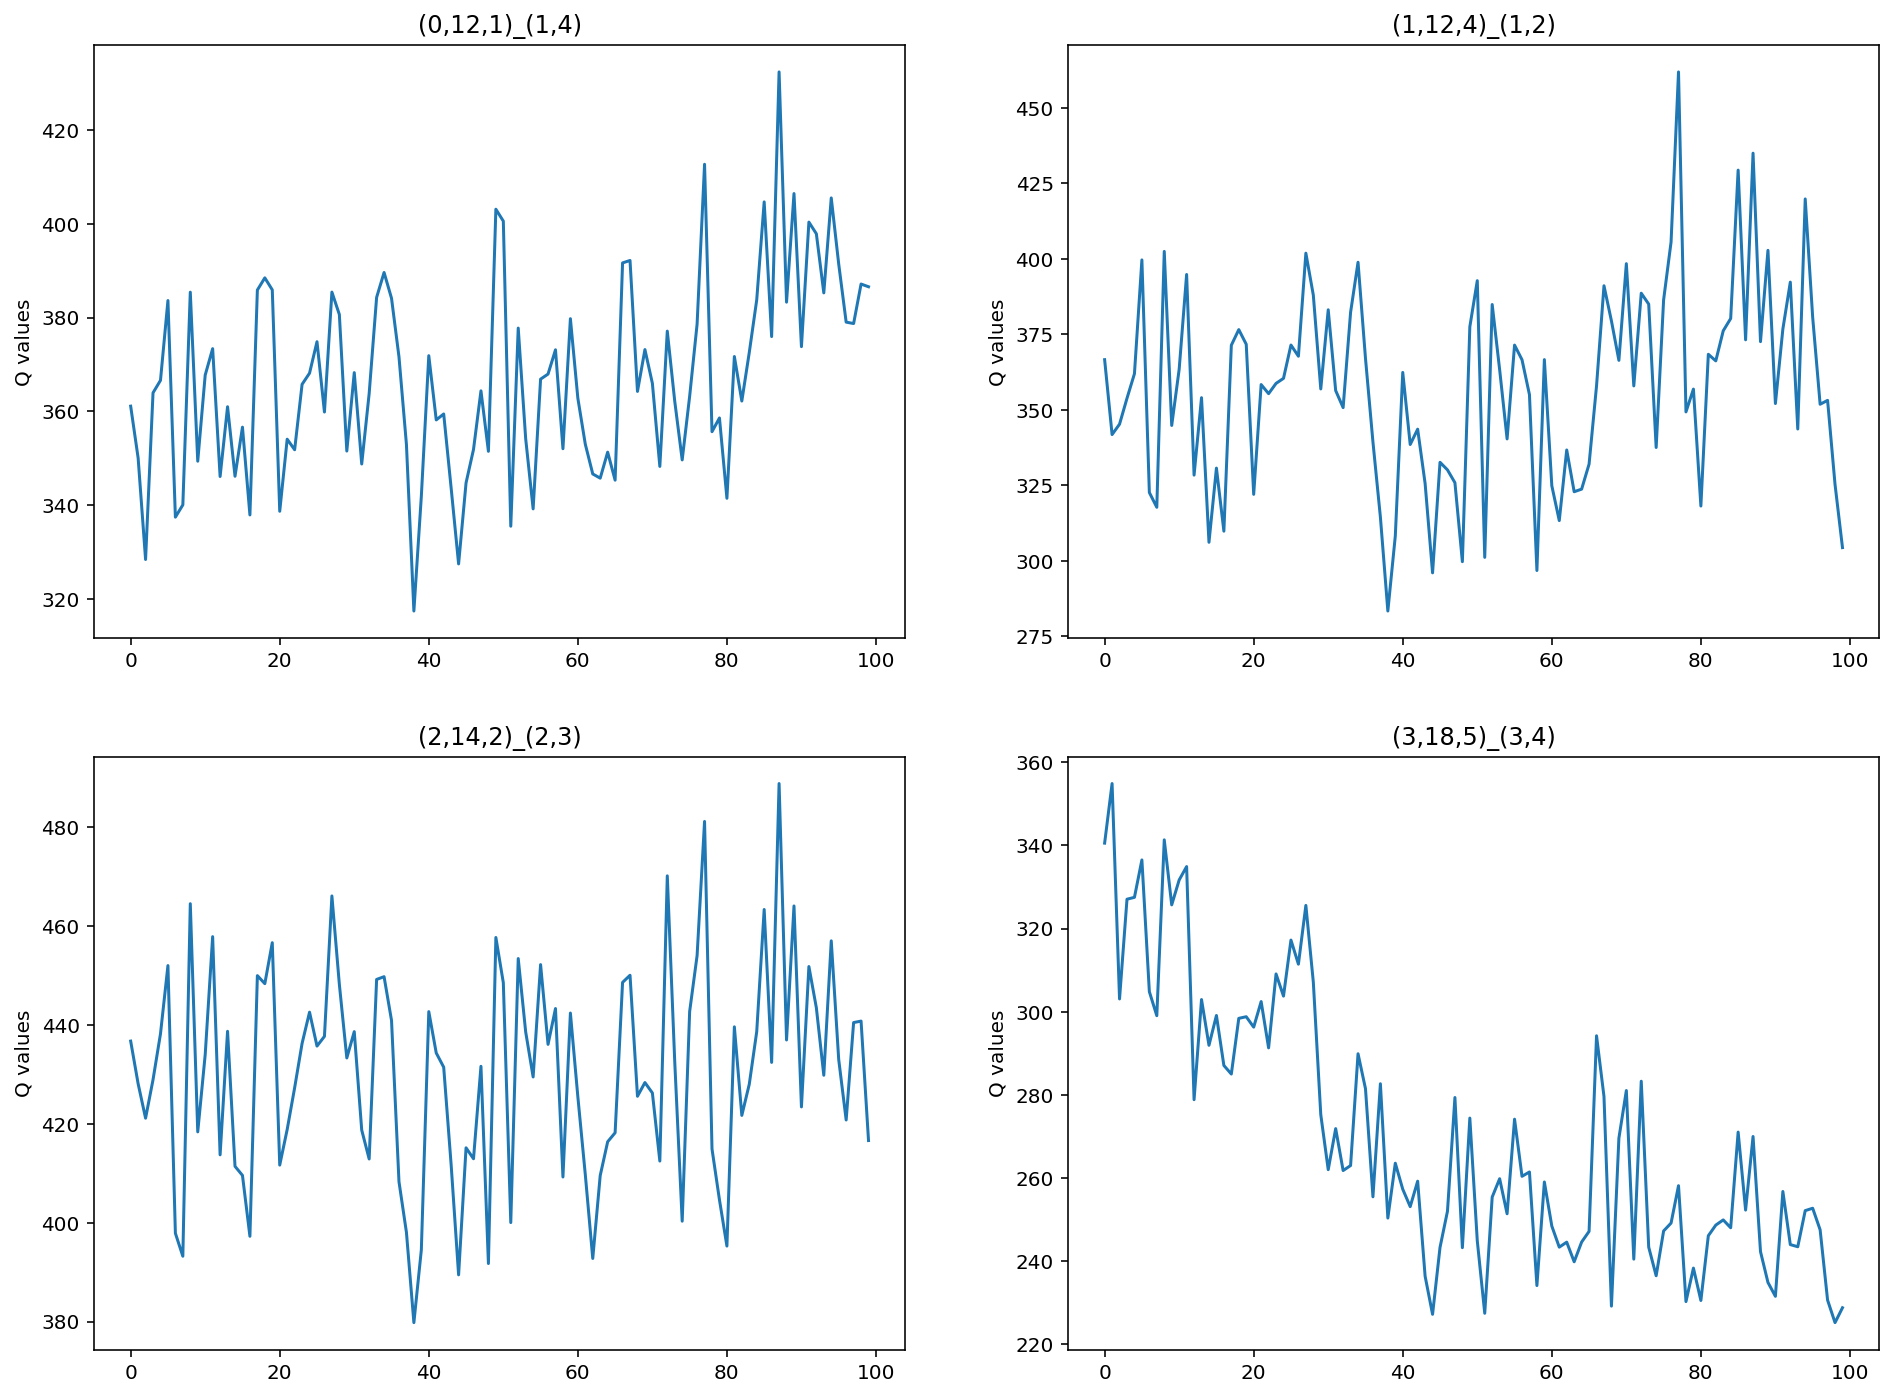

In [21]:
plot_tracked_values(agent.states_track, big=True, limit_values_from_last=100)